# Potato Disease Classification

In [1]:
from google.colab import drive
drive.mount('mydrive')

Mounted at mydrive


In [15]:
from zipfile import ZipFile
file_name = "/content/mydrive/MyDrive/My Files/Datasets/Plant Disease/Potato.zip"

with ZipFile(file_name, 'r') as zip:
    zip.extractall('data/')
    print("Done")

del zip

Done


In [16]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [17]:
tf.__version__

'2.15.0'

In [18]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [19]:
os.listdir('data')

['Potato___Late_blight', 'Potato___Early_blight', 'Potato___healthy']

In [20]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [21]:
class_names = dataset.class_names
class_names = list(map(lambda x: x.split('___')[-1], class_names))
class_names

['Early_blight', 'Late_blight', 'healthy']

In [22]:
dataset.as_numpy_iterator().next()[0].shape

(32, 256, 256, 3)

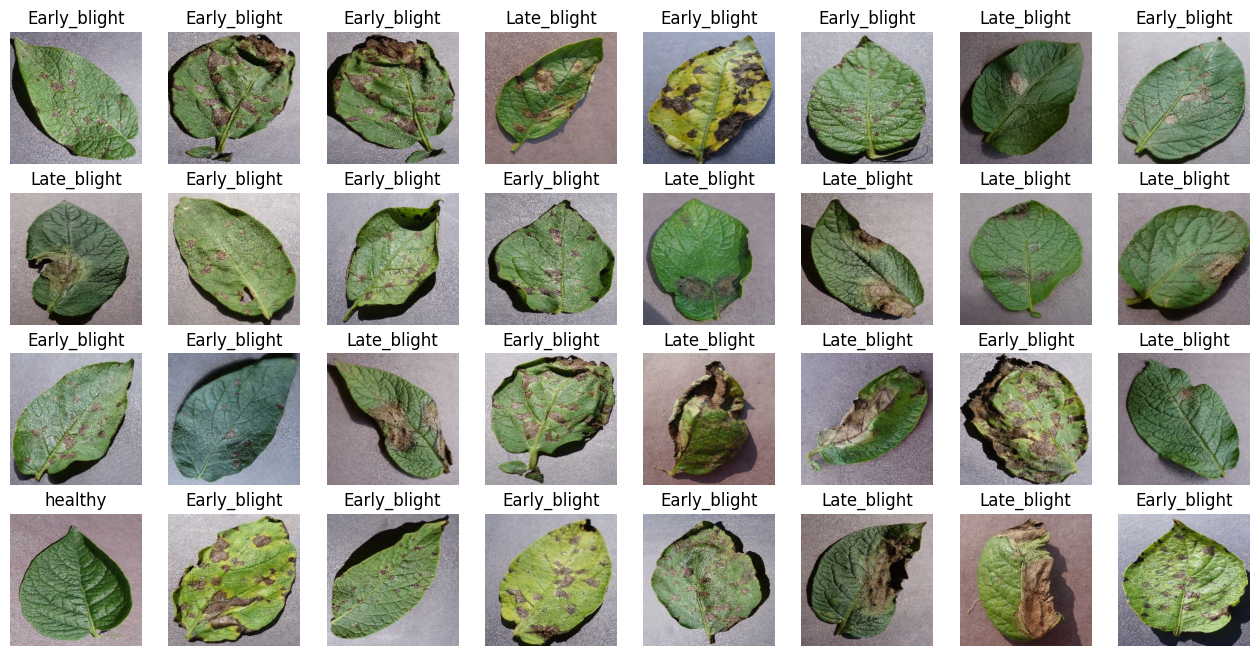

In [23]:
images, labels = dataset.as_numpy_iterator().next()

plt.figure(figsize=(16, 8))
for index, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4, 8, index + 1)
    plt.imshow(image.astype('uint8'))
    plt.title(class_names[label])
    plt.axis('off')

In [24]:
len(dataset)

68

In [25]:
train_ds, test_ds = dataset.take(54), dataset.skip(54)

len(train_ds), len(test_ds)

(54, 14)

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

In [28]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [29]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = tf.keras.models.Sequential([
    resize_and_rescale,
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
history = model.fit(train_ds, batch_size=BATCH_SIZE, validation_data=test_ds, verbose=1, epochs=50)

Epoch 1/50
54/54 [==============================] - 33s 401ms/step - loss: 0.9361 - accuracy: 0.4537 - val_loss: 0.8751 - val_accuracy: 0.4646
Epoch 2/50
54/54 [==============================] - 17s 319ms/step - loss: 0.8315 - accuracy: 0.5671 - val_loss: 0.7038 - val_accuracy: 0.6509
Epoch 3/50
54/54 [==============================] - 16s 290ms/step - loss: 0.5362 - accuracy: 0.7714 - val_loss: 0.6828 - val_accuracy: 0.7028
Epoch 4/50
54/54 [==============================] - 17s 307ms/step - loss: 0.4226 - accuracy: 0.8247 - val_loss: 0.5869 - val_accuracy: 0.7193
Epoch 5/50
54/54 [==============================] - 17s 316ms/step - loss: 0.2729 - accuracy: 0.8929 - val_loss: 0.2053 - val_accuracy: 0.9481
Epoch 6/50
54/54 [==============================] - 17s 308ms/step - loss: 0.2486 - accuracy: 0.9051 - val_loss: 0.3887 - val_accuracy: 0.8538
Epoch 7/50
54/54 [==============================] - 17s 309ms/step - loss: 0.1235 - accuracy: 0.9566 - val_loss: 0.4798 - val_accuracy: 0.8443

In [34]:
scores = model.evaluate(test_ds)
scores

14/14 [==============================] - 1s 35ms/step - loss: 0.0624 - accuracy: 0.9764


[0.06244524195790291, 0.9764150977134705]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

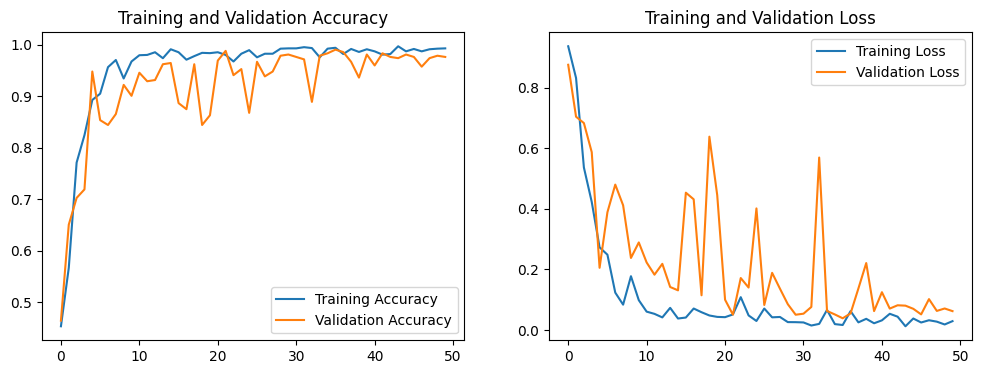

In [38]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
def predict(model, img):
    img = np.expand_dims(img, 0)
    predictions = model.predict(img)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


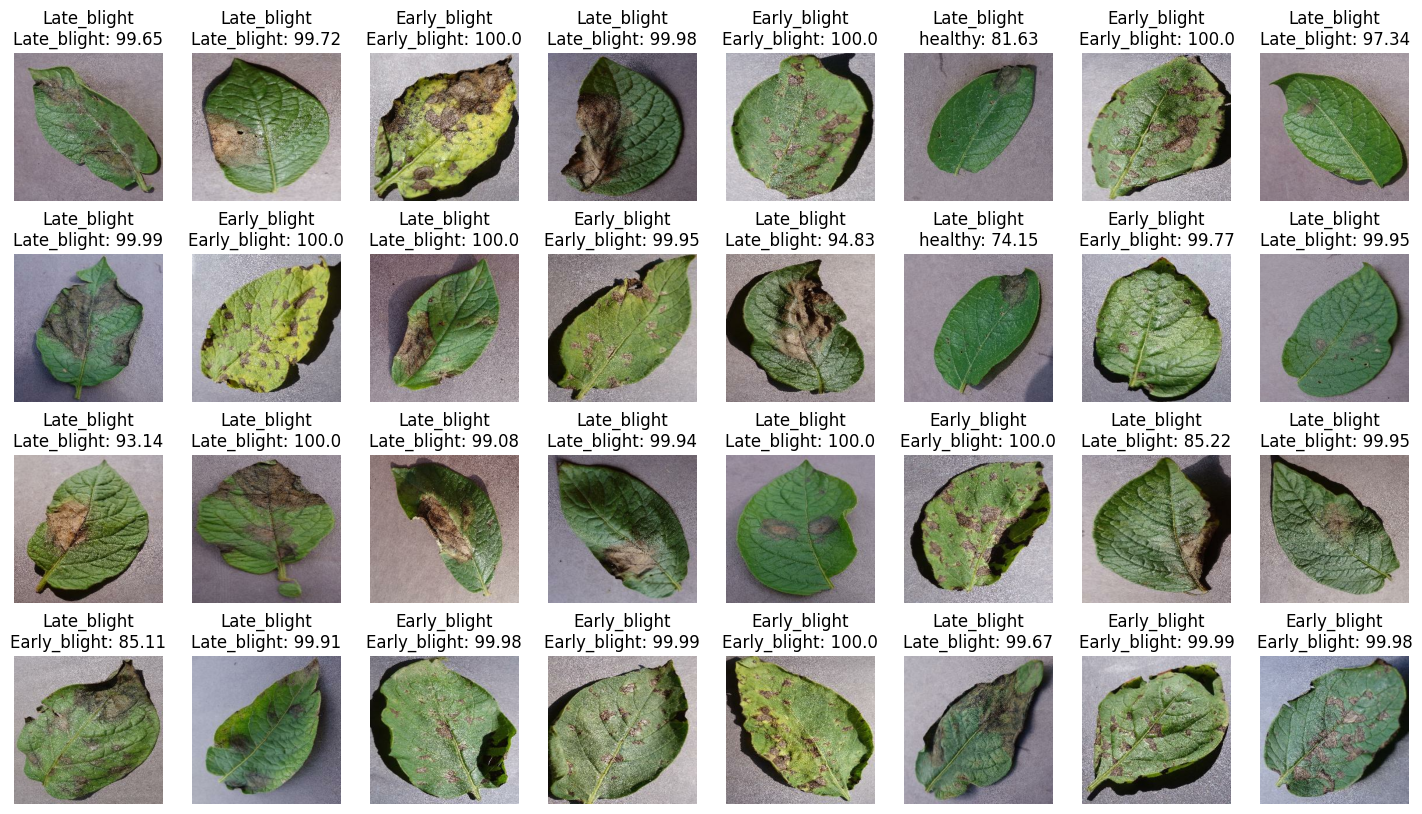

In [47]:
images, labels = test_ds.as_numpy_iterator().next()

plt.figure(figsize=(18, 10))
for index, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4, 8, index + 1)
    plt.imshow(image.astype("uint8"))
    prediction, confidence = predict(model, image)
    plt.title(f'{class_names[label]}\n{prediction}: {confidence}')
    plt.axis('off')
plt.show()

In [49]:
model.save('potato.keras')

In [50]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [51]:
tflite_model = converter.convert()

In [52]:
with open('potato.tflite', 'wb') as f:
  f.write(tflite_model)